# PXD030782
## Peroxisome-derived hydrogen peroxide can modulate the sulfenylation profiles of key redox signaling proteins in Flp-In T-REx 293 cells

[Pride link](https://www.ebi.ac.uk/pride/archive/projects/PXD030782)

[Article link](https://pubmed.ncbi.nlm.nih.gov/35557958/)

IMPORTANT! In this dataset, sulfenylated proteins were enriched (might not be useable since all PSMs come from proteins that have been modified anyway)

In [59]:
#Import libraries
os.chdir("/home/robbe/ionbot/")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import os
from pathlib import Path
from pyteomics import mass as pymass
import OxiAnalysis as OA
import importlib
importlib.reload(OA)
import warnings; warnings.simplefilter('ignore')

# Analysis without quant data

In [2]:
first = pd.read_csv('/home/robbe/ionbot/full_projects/PXD030782_first.csv')
del first["Unnamed: 0"]
del first["spectrum_title"]
del first["scan"]
first['modifications'] = first['modifications'].fillna("None")
first['Oxidant treatment'] = first['Oxidant treatment'].fillna("None")
first['Secondary treatment'] = first['Secondary treatment'].fillna("None")
first['Length of Secondary treatment (mins)'] = first['Length of Secondary treatment (mins)'].fillna(0)
first['Length of Secondary treatment (mins)'] = first['Length of Secondary treatment (mins)'].replace('0', 0)
first['Length of oxidant treatment (mins)'] = first['Length of oxidant treatment (mins)'].replace('0', 0)

In [3]:
print("The amount of PSMs in this project dataset is: ", first.shape[0])
print("The amount of raw files that make up the master dataset is: ", len(first["spectrum_file"].unique()))

The amount of PSMs in this project dataset is:  65490
The amount of raw files that make up the master dataset is:  12


In [4]:
first['spectrum_file'].unique()

array(['Experiment 1_extH2O2_c-YAP_0 mM H2O2',
       'Experiment 1_extH2O2_c-YAP_1 mM H2O2',
       'Experiment 1_extH2O2_mt-YAP_0 mM H2O2',
       'Experiment 1_extH2O2_mt-YAP_1 mM H2O2',
       'Experiment 1_extH2O2_po-YAP_0 mM H2O2',
       'Experiment 1_extH2O2_po-YAP_1 mM H2O2',
       'Experiment 4_extH2O2_c-YAP_concentration curve_0 uM',
       'Experiment 4_extH2O2_c-YAP_concentration curve_1000 uM',
       'Experiment 4_extH2O2_c-YAP_concentration curve_100 uM',
       'Experiment 4_extH2O2_c-YAP_concentration curve_10 uM',
       'Experiment 4_extH2O2_c-YAP_concentration curve_300 uM',
       'Experiment 4_extH2O2_c-YAP_concentration curve_30 uM'],
      dtype=object)

In [5]:
first['Peptidoform_name'] = first.apply(lambda row: OA.peptidoform_name(row), axis=1)
first['Position'] = first['modifications'].apply(OA.get_positions)
first['Modification'] = first['modifications'].apply(OA.get_modification)
first['Oxidatively_modified'] = first['modifications'].apply(OA.oxidatively_modified)

## Overview of the treatments in this project

In [6]:
first.groupby(["Oxidant treatment", "Oxidant dose (µM)", "Length of oxidant treatment (mins)", "Secondary treatment", "Secondary treatment dose (µM)", 'Length of Secondary treatment (mins)'])["ionbot_match_id"].count().to_frame().reset_index()

,Oxidant treatment,Oxidant dose (µM),Length of oxidant treatment (mins),Secondary treatment,Secondary treatment dose (µM),Length of Secondary treatment (mins),ionbot_match_id
0,H2O2,10,10,c-YAP,0,0,6509
1,H2O2,30,10,c-YAP,0,0,7071
2,H2O2,100,10,c-YAP,0,0,7500
3,H2O2,300,10,c-YAP,0,0,7498
4,H2O2,1000,10,c-YAP,0,0,11183
5,H2O2,1000,10,mt-YAP,0,0,4079
6,H2O2,1000,10,po-YAP,0,0,3054
7,None,0,0,c-YAP,0,0,10299
8,None,0,0,mt-YAP,0,0,4314
9,None,0,0,po-YAP,0,0,3983


### Conditions that will be compared

| N | Treatment | Treatment 2 | Treatment 3|
| - | ----------- | ----------- | -------- |
| 1 | None c-YAP | None mt-YAP | None po-YAP |
| 2 | None c-YAP | H2O2 c-YAP | -- |
| 3 | None mt-YAP | H2O2 mt-YAP | -- |
| 4 | None po-YAP | H2O2 po-YAP | -- |

And then a concentration-dependend analysis with condition 0-4 en 7

In [7]:
H2O2c10 = first.loc[lambda first: (first["Oxidant dose (µM)"] == 10)]
H2O2c30 = first.loc[lambda first: (first["Oxidant dose (µM)"] == 30)]
H2O2c100 = first.loc[lambda first: (first["Oxidant dose (µM)"] == 100)]
H2O2c300 = first.loc[lambda first: (first["Oxidant dose (µM)"] == 300)]
H2O2c1000 = first.loc[lambda first: (first["Oxidant dose (µM)"] == 1000) &  (first["Secondary treatment"] == "c-YAP")]
H2O2mt1000 = first.loc[lambda first: (first["Oxidant treatment"] == "H2O2") & (first["Secondary treatment"] == "mt-YAP")]
H2O2po1000 = first.loc[lambda first: (first["Oxidant treatment"] == "H2O2") & (first["Secondary treatment"] == "po-YAP")]
Nonec = first.loc[lambda first: (first["Oxidant treatment"] == "None") & (first["Secondary treatment"] == "c-YAP")]
Nonemt = first.loc[lambda first: (first["Oxidant treatment"] == "None") & (first["Secondary treatment"] == "mt-YAP")]
Nonepo = first.loc[lambda first: (first["Oxidant treatment"] == "None") & (first["Secondary treatment"] == "po-YAP")]

## Comparison between the treatments
### 1) No treatment, with proteins isolated from cytosol, mitochondria and peroxisomes

In [8]:
print("There are this many replicates of None-c treatment: {}".format(Nonec["spectrum_file"].nunique()))
print("There are this many replicates of None-mt treatment: {}".format(Nonemt["spectrum_file"].nunique()))
print("There are this many replicates of None-po treatment: {}".format(Nonepo["spectrum_file"].nunique()))

There are this many replicates of None-c treatment: 2
There are this many replicates of None-mt treatment: 1
There are this many replicates of None-po treatment: 1


In [9]:
Nonecrep = OA.replicate_filter(Nonec,2)
Nonemtrep = OA.replicate_filter(Nonemt,1)
Noneporep = OA.replicate_filter(Nonepo,1)

In [10]:
print("The ratio of PSMs that contain an oxidative modification in the None-c treatment subset: {}".format((Nonecrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))
print("The ratio of PSMs that contain an oxidative modification in the None-mt treatment subset: {}".format((Nonemtrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))
print("The ratio of PSMs that contain an oxidative modification in the None-po treatment subset: {}".format((Nonepo['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))

The ratio of PSMs that contain an oxidative modification in the None-c treatment subset: 13.595397890699903 %
The ratio of PSMs that contain an oxidative modification in the None-mt treatment subset: 13.931386184515532 %
The ratio of PSMs that contain an oxidative modification in the None-po treatment subset: 16.01807682651268 %


In [11]:
mrNonecrep = OA.modratios(Nonecrep)
mrNonemtrep = OA.modratios(Nonemtrep)
mrNoneporep = OA.modratios(Noneporep)

In [12]:
modr_temp = pd.merge(mrNonemtrep, mrNoneporep, on="Modification", suffixes=('_mt', '_po'))
modr = pd.merge(modr_temp, mrNonecrep, on="Modification")
modr = modr.rename(columns={'Ratios':'Ratios_c'})
modr = modr.drop(modr[(modr["Ratios_mt"] == 0) | (modr["Ratios_po"] == 0) | (modr["Ratios_c"] == 0)].index)
modr

,Modification,Ratios_mt,Ratios_po,Ratios_c
0,[35]Oxidation[T],0.001518,0.001704,0.001272
8,[35]Oxidation[W],0.031746,0.037143,0.076010
11,[35]Oxidation[V],0.001231,0.001355,0.000767
17,[35]Oxidation[N],0.000950,0.000668,0.001093
29,[368]Cys->Dha[C],0.030233,0.038235,0.066434
33,[345]Trioxidation[C],0.037209,0.055882,0.090909
38,[351]Trp->Kynurenin[W],0.018519,0.025714,0.023753
41,[129]Iodo[Y],0.006504,0.011383,0.010743
44,[360]Pro->Pyrrolidinone[P],0.001695,0.001927,0.002815
68,[401]Didehydro[S],0.000524,0.000539,0.000280


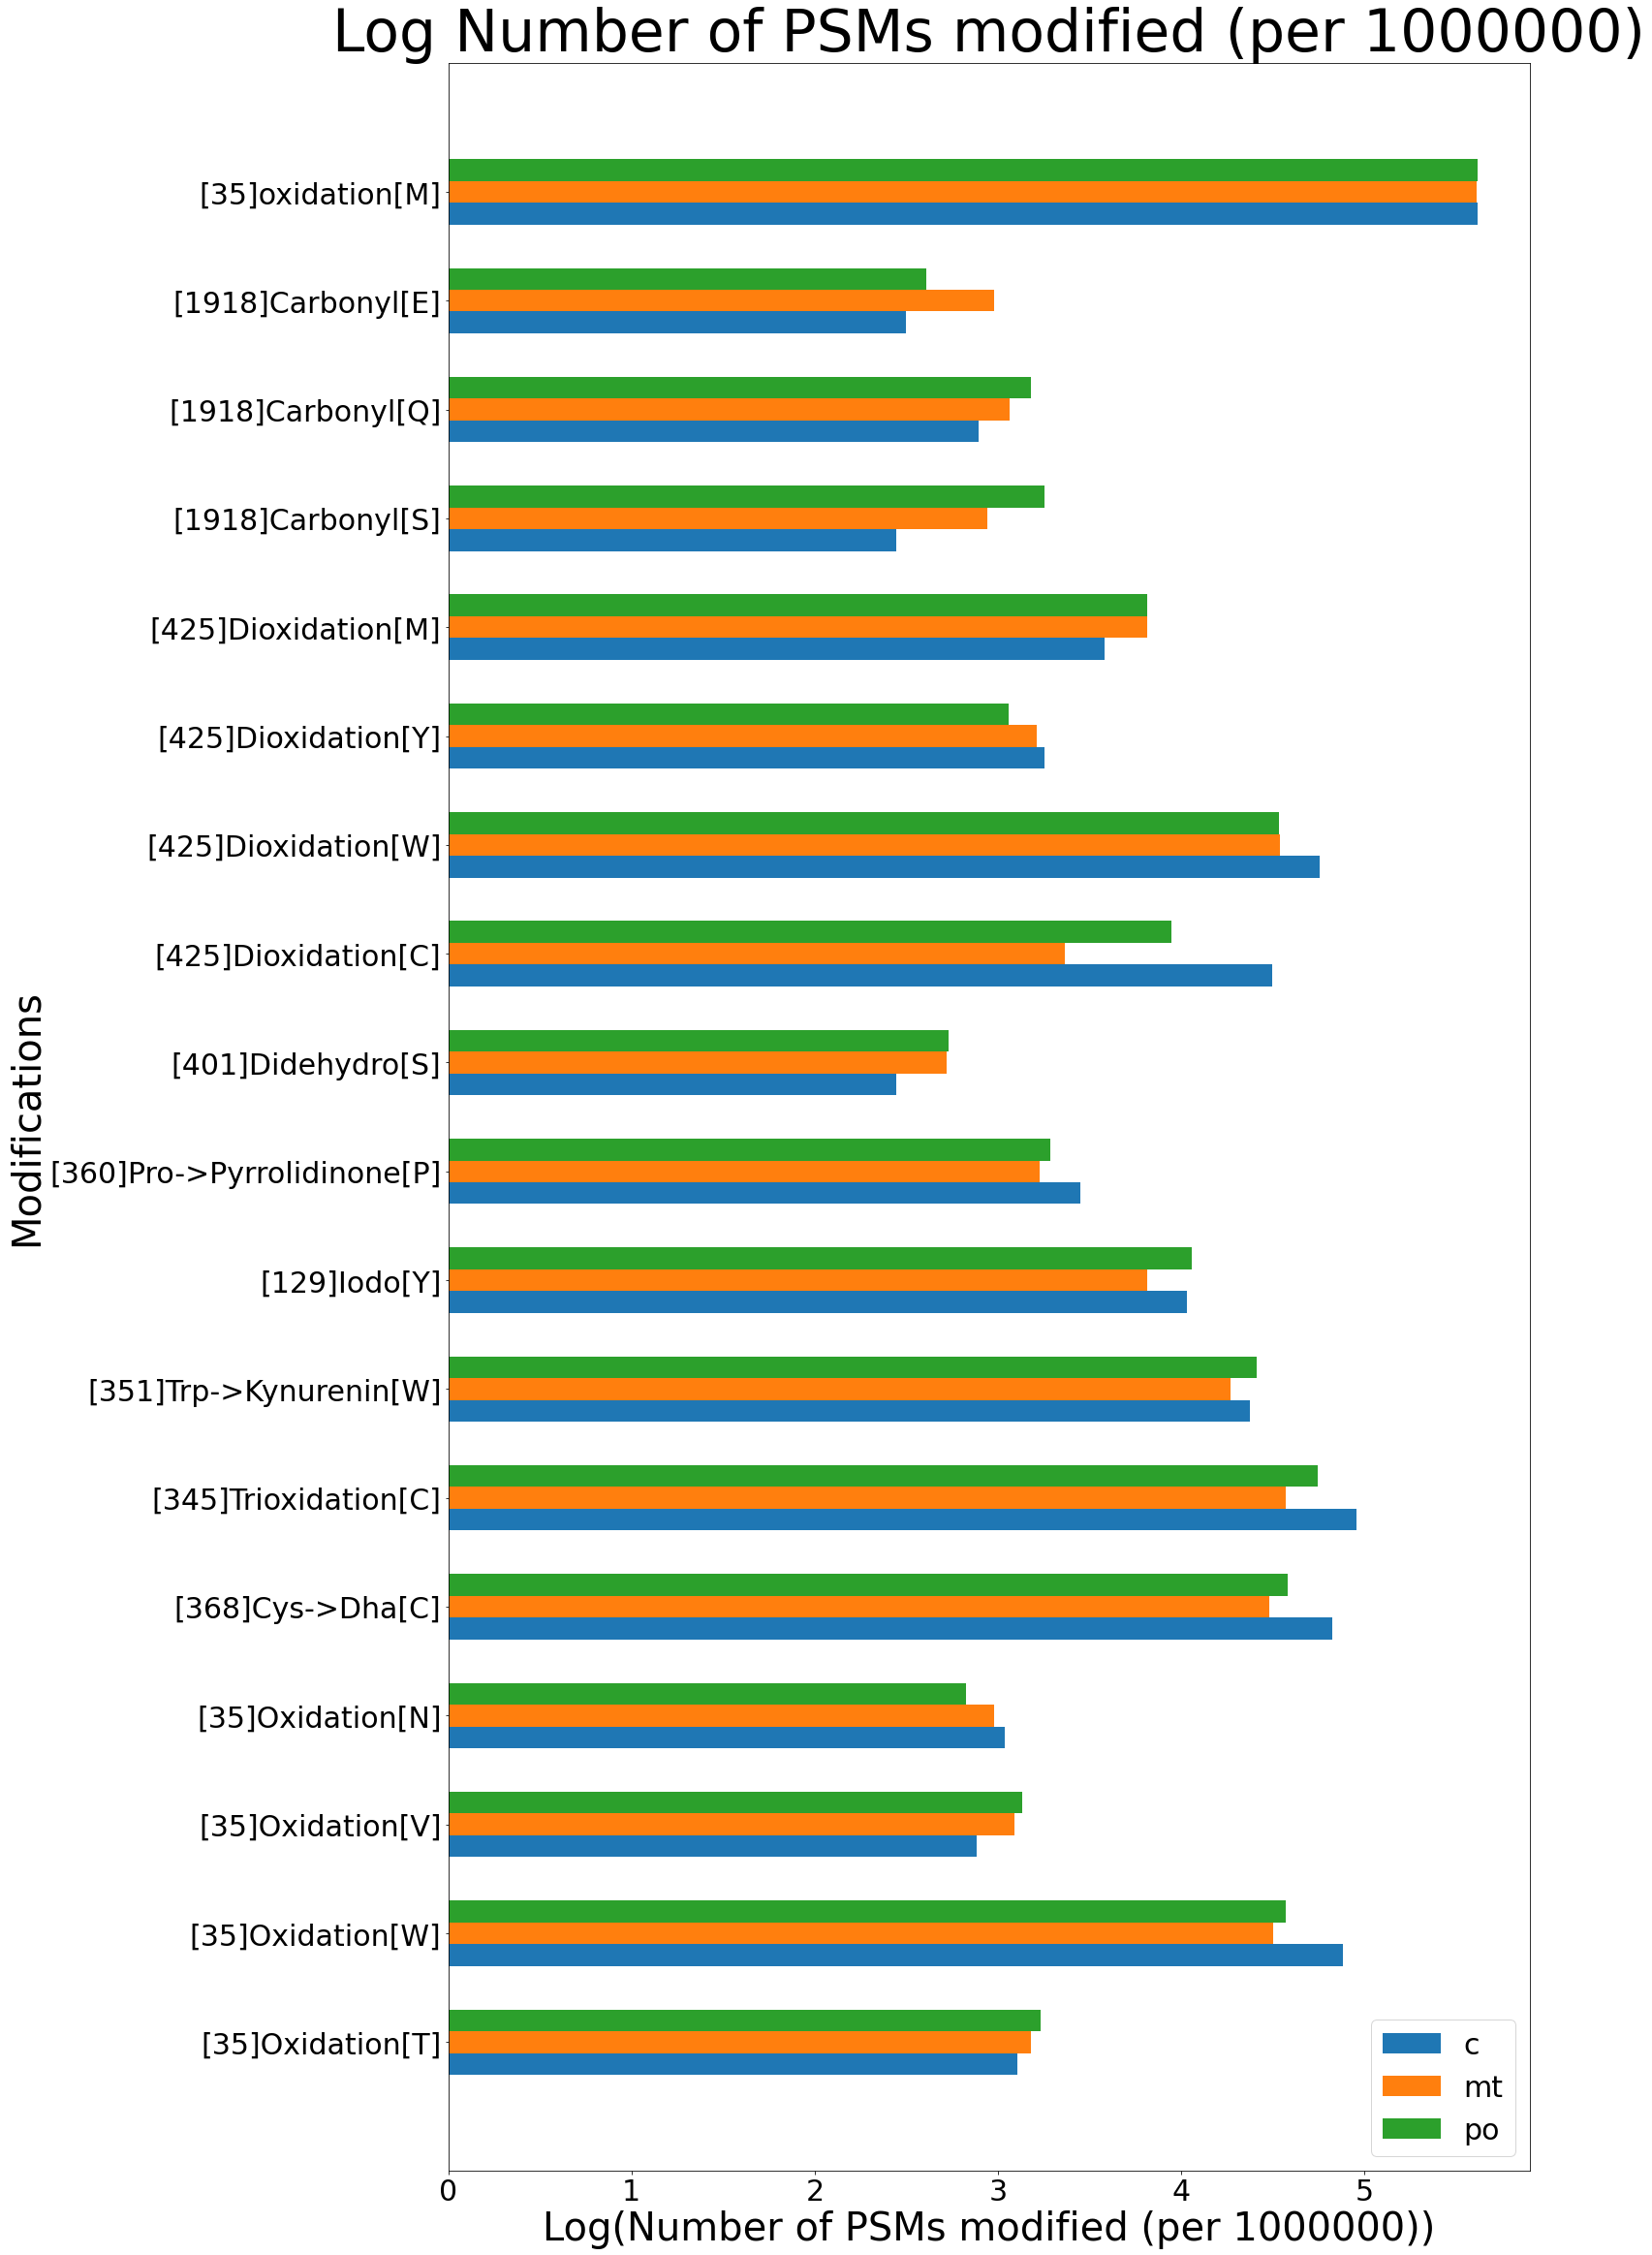

In [13]:
y = modr["Modification"]
xGlu = np.log10(modr['Ratios_c']*1000000)
xstGal = np.log10(modr['Ratios_mt']*1000000)
xltGal = np.log10(modr['Ratios_po']*1000000)
y_axis = np.arange(len(y))
plt.figure(figsize=(20,40))
plt.barh(y_axis - 0.2, xGlu, 0.2, label = 'c')
plt.barh(y_axis, xstGal, 0.2, label = 'mt')
plt.barh(y_axis + 0.2, xltGal, 0.2, label = 'po')

plt.yticks(y_axis, y)
plt.ylabel("Modifications", fontsize = 40)
plt.xlabel("Log(Number of PSMs modified (per 1000000))", fontsize = 40)
plt.title("Log Number of PSMs modified (per 1000000)", fontsize = 60)
plt.tick_params(axis='both', which='major', labelsize=30)
plt.legend(fontsize = 30)
plt.show()

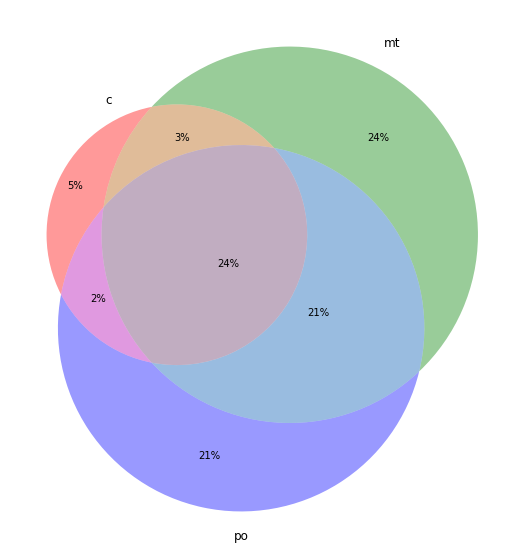

In [14]:
OA.condition_venn([Nonecrep,Nonemtrep,Noneporep], ["c", "mt", "po"])

In [15]:
RPMNonec = OA.relative_PSM_modification(Nonecrep)
RPMNonemt = OA.relative_PSM_modification(Nonemtrep)
RPMNonepo = OA.relative_PSM_modification(Noneporep)

In [16]:
RPM = pd.merge(RPMNonec, RPMNonemt, on="Amino acid", suffixes=('_Nonec','_Nonemt'))
RPM = pd.merge(RPM, RPMNonepo, on="Amino acid")
RPM = RPM.rename(columns={"Relative level of PSMs containing unmodified residue" : "Relative level of PSMs containing unmodified residue_Nonepo"})
RPM

,Amino acid,Relative level of PSMs containing unmodified residue_Nonec,Relative level of PSMs containing unmodified residue_Nonemt,Relative level of PSMs containing unmodified residue_Nonepo
0,A,1.000000,0.996799,0.996107
1,R,0.996608,0.987730,0.984092
2,N,0.939947,0.933856,0.931461
3,D,0.988297,0.964401,0.962963
4,C,0.050000,0.114634,0.113208
5,Q,0.986941,0.976310,0.968959
6,E,0.989934,0.953757,0.945926
7,G,1.000000,0.999006,0.997831
8,H,0.991726,0.985075,0.973829
9,I,1.000000,0.998071,0.995244


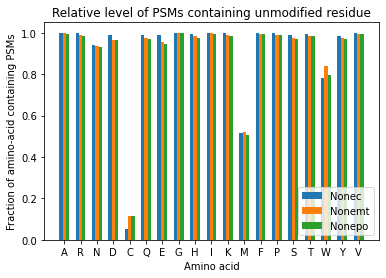

In [17]:
x = RPM["Amino acid"]
xGlu = RPM["Relative level of PSMs containing unmodified residue_Nonec"]
xst = RPM['Relative level of PSMs containing unmodified residue_Nonemt']
xlt = RPM['Relative level of PSMs containing unmodified residue_Nonepo']
x_axis = np.arange(len(x))

plt.bar(x_axis - 0.2, xGlu, 0.2, label = 'Nonec')
plt.bar(x_axis, xst, 0.2, label = 'Nonemt')
plt.bar(x_axis + 0.2, xlt, 0.2, label = 'Nonepo')

plt.xticks(x_axis, x)
plt.xlabel("Amino acid")
plt.ylabel("Fraction of amino-acid containing PSMs")
plt.title("Relative level of PSMs containing unmodified residue")
plt.rcParams["figure.figsize"] = (20,20)
plt.legend(loc="lower right")
plt.show()

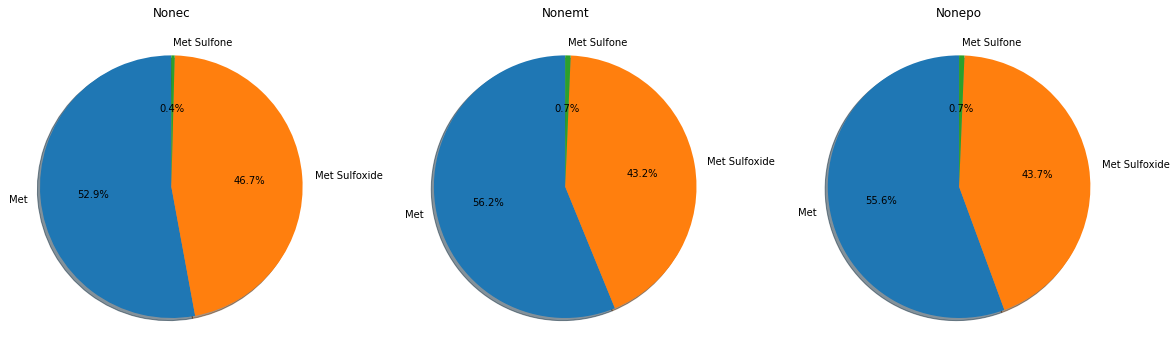

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
OA.methionine_overview(Nonecrep, ax1)
OA.methionine_overview(Nonemtrep, ax2)
OA.methionine_overview(Noneporep, ax3)
plt.title("Methionine containing peptides")
ax1.set_title("Nonec")
ax2.set_title("Nonemt")
ax3.set_title("Nonepo")
plt.show()

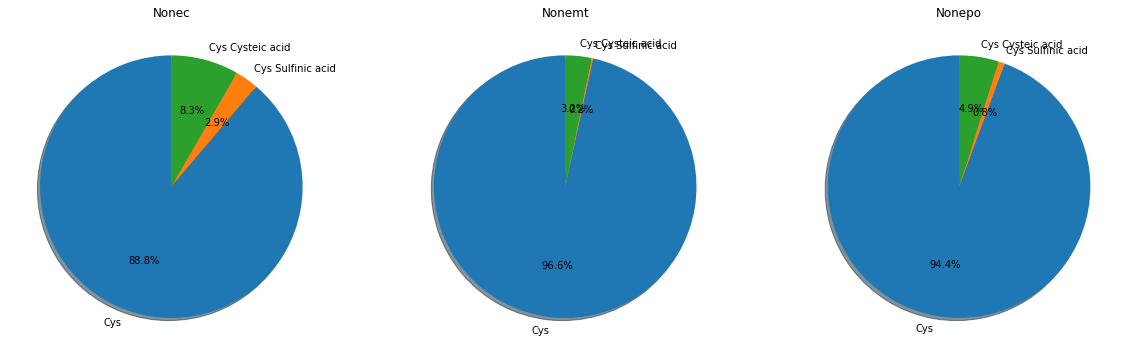

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
OA.cysteine_overview(Nonecrep, ax1)
OA.cysteine_overview(Nonemtrep, ax2)
OA.cysteine_overview(Noneporep, ax3)
plt.title("cysteine containing peptides")
ax1.set_title("Nonec")
ax2.set_title("Nonemt")
ax3.set_title("Nonepo")
plt.show()

### None c-YAP vs H2O2 c-YAP

In [20]:
print("There are this many replicates of the H2O2 c-YAP (1000 µM) treatment: {}".format(H2O2c1000["spectrum_file"].nunique()))

There are this many replicates of the H2O2 c-YAP (1000 µM) treatment: 2


In [21]:
H2O2c1000rep = OA.replicate_filter(H2O2c1000, 2)


In [22]:
print("The ratio of PSMs that contain an oxidative modification in the H2O2 c-YAP treatment subset: {}".format((H2O2c1000rep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))
print("The ratio of PSMs that contain an oxidative modification in the Control c-YAP treatment subset: {}".format((Nonecrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))

The ratio of PSMs that contain an oxidative modification in the H2O2 c-YAP treatment subset: 12.764932562620423 %
The ratio of PSMs that contain an oxidative modification in the Control c-YAP treatment subset: 13.595397890699903 %


In [23]:
mrH2O2c1000rep = OA.modratios(H2O2c1000rep)

In [24]:
modr2 = pd.merge(mrH2O2c1000rep,mrNonecrep, on="Modification", suffixes=('_H2O2', '_Control'))
modr2["Difference"] = modr2["Ratios_H2O2"] - modr2["Ratios_Control"]
modr2 = modr2.drop(modr2[(modr2["Ratios_H2O2"] == 0) & (modr2["Ratios_Control"] == 0)].index)
modr2

,Modification,Ratios_H2O2,Ratios_Control,Difference
0,[35]Oxidation[T],0.001968,0.001272,0.000696
3,[35]Oxidation[Q],0.000670,0.000000,0.000670
5,[35]Oxidation[I],0.000437,0.000000,0.000437
8,[35]Oxidation[W],0.061224,0.076010,-0.014785
10,[35]Oxidation[H],0.008759,0.000000,0.008759
11,[35]Oxidation[V],0.001528,0.000767,0.000761
17,[35]Oxidation[N],0.000000,0.001093,-0.001093
29,[368]Cys->Dha[C],0.103825,0.066434,0.037392
33,[345]Trioxidation[C],0.043716,0.090909,-0.047193
38,[351]Trp->Kynurenin[W],0.061224,0.023753,0.037472


/home/robbe/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


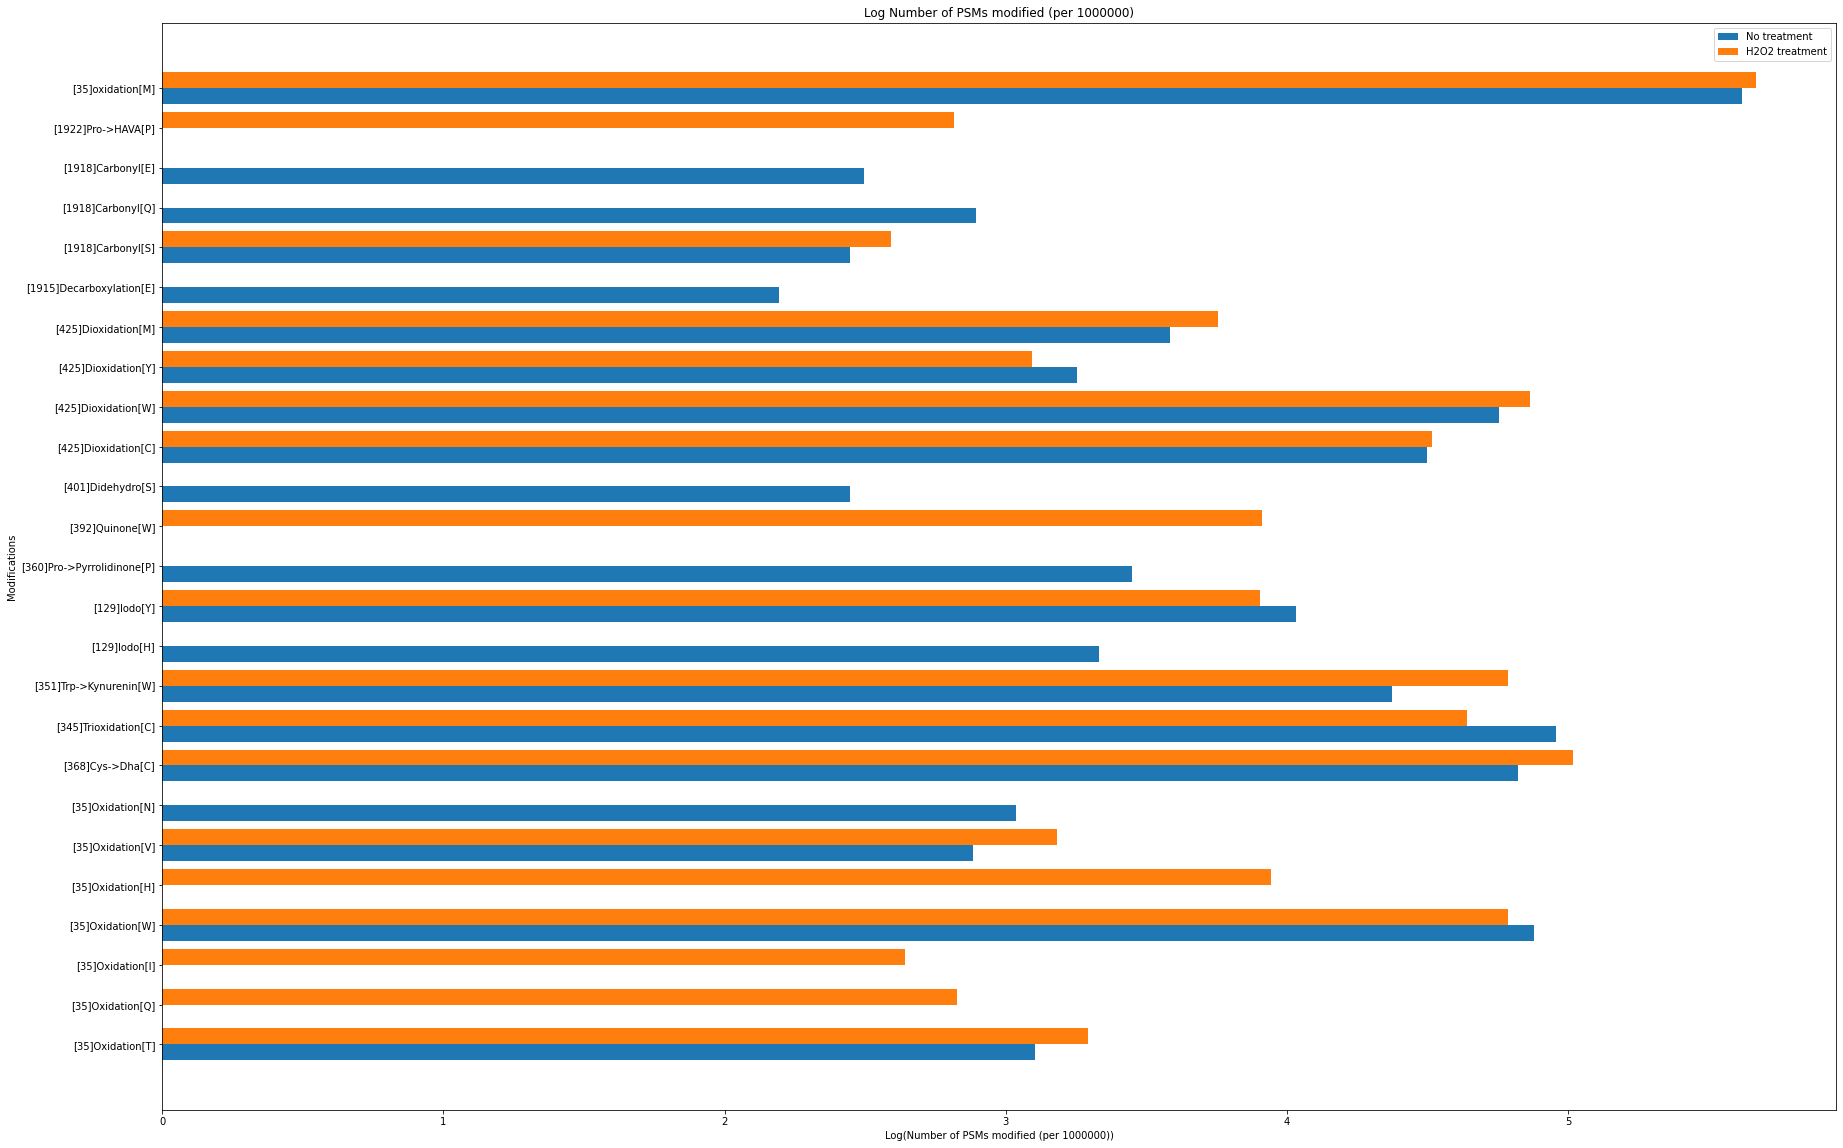

In [25]:
y = modr2["Modification"]
xnone = np.log10(modr2['Ratios_Control']*1000000)
xH = np.log10(modr2['Ratios_H2O2']*1000000)
y_axis = np.arange(len(y))

plt.figure(figsize=(30,20))
plt.barh(y_axis - 0.2, xnone, 0.4, label = 'No treatment')
plt.barh(y_axis + 0.2, xH, 0.4, label = 'H2O2 treatment')

plt.yticks(y_axis, y)
plt.ylabel("Modifications")
plt.xlabel("Log(Number of PSMs modified (per 1000000))")
plt.title("Log Number of PSMs modified (per 1000000)")

plt.legend()
plt.show()

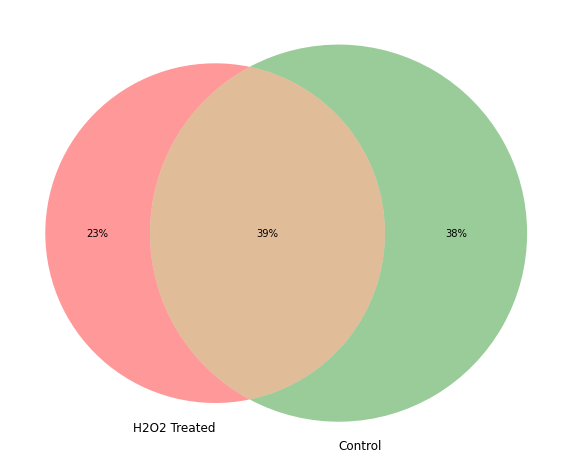

In [26]:
OA.condition_venn([H2O2c1000rep, Nonecrep], ["H2O2 Treated", "Control"])

In [27]:
difflist, pf_only_treatment = OA.comparelist(H2O2c1000rep,Nonecrep)
pf_only_treatment.head()

,ionbot_match_id,spectrum_file,precursor_mass,peptide_mass,observed_retention_time,charge,database_peptide,matched_peptide,modifications,modifications_delta,...,Secondary treatment,Secondary treatment dose (µM),Length of oxidant treatment (mins),Length of Secondary treatment (mins),Notes,First/Lower/Coeluting,Peptidoform_name,Position,Modification,Oxidatively_modified
3401,0_6428_2,Experiment 1_extH2O2_c-YAP_1 mM H2O2,1273.72190,12737.1826,2350.39746,2,IIVVYPWTQR,IIVVYPWTQR,None,0|,...,c-YAP,0,10,0,YAP1C can react with and trap protein sulfenic...,First,IIVVYPWTQR,None,None,False
3414,0_6489_1,Experiment 1_extH2O2_c-YAP_1 mM H2O2,1555.77683,15557.7042,2364.76938,2,VVIGMDVAASEFFR,VVIGMDVAASEFFR,5|[35]oxidation[M],5|15.9949,...,c-YAP,0,10,0,YAP1C can react with and trap protein sulfenic...,First,VVIGM[35]oxidationDVAASEFFR,5,[35]oxidation[M],True
3421,0_6499_1,Experiment 1_extH2O2_c-YAP_1 mM H2O2,1193.64756,12106.6695,2367.32550,2,QITVNDIPVGR,QITVNDIPVGR,3|[385]Ammonia-loss[T],3|-17.0265,...,c-YAP,0,10,0,YAP1C can react with and trap protein sulfenic...,First,QIT[385]Ammonia-lossVNDIPVGR,3,[385]Ammonia-loss[T],False
3433,0_6528_3,Experiment 1_extH2O2_c-YAP_1 mM H2O2,1204.54416,12045.4093,2374.36104,2,CMPTFQFFK,CMPTFQFFK,1|[4]carbamidomethyl[C],1|57.0215,...,c-YAP,0,10,0,YAP1C can react with and trap protein sulfenic...,First,C[4]carbamidomethylMPTFQFFK,1,[4]carbamidomethyl[C],False
3438,0_6537_1,Experiment 1_extH2O2_c-YAP_1 mM H2O2,1160.66269,11606.5870,2377.46802,2,TMQTIISIVR,TMQTIISIVR,None,0|,...,c-YAP,0,10,0,YAP1C can react with and trap protein sulfenic...,First,TMQTIISIVR,None,None,False


In [28]:
onlytreatment = OA.modcounts(pf_only_treatment)
onlytreatment = onlytreatment.sort_values("Counts", ascending=False).drop(onlytreatment[onlytreatment["Counts"] == 0].index, axis=0)
onlytreatment

,Modification,Counts
129,[35]oxidation[M],103
38,[351]Trp->Kynurenin[W],10
10,[35]Oxidation[H],6
41,[129]Iodo[Y],4
29,[368]Cys->Dha[C],3
5,[35]Oxidation[I],3
76,[425]Dioxidation[C],2
80,[425]Dioxidation[M],2
66,[392]Quinone[W],2
3,[35]Oxidation[Q],2


In [29]:
RPMH2O2c1000 = OA.relative_PSM_modification(H2O2c1000rep)

In [30]:
RPM2 = pd.merge(RPMH2O2c1000, RPMNonec, on="Amino acid", suffixes=('_cH2O2','_cControl'))
RPM2

,Amino acid,Relative level of PSMs containing unmodified residue_cH2O2,Relative level of PSMs containing unmodified residue_cControl
0,A,1.000000,1.000000
1,R,0.998275,0.996608
2,N,0.949035,0.939947
3,D,0.999094,0.988297
4,C,0.022222,0.050000
5,Q,0.984367,0.986941
6,E,1.000000,0.989934
7,G,1.000000,1.000000
8,H,0.987200,0.991726
9,I,0.999145,1.000000


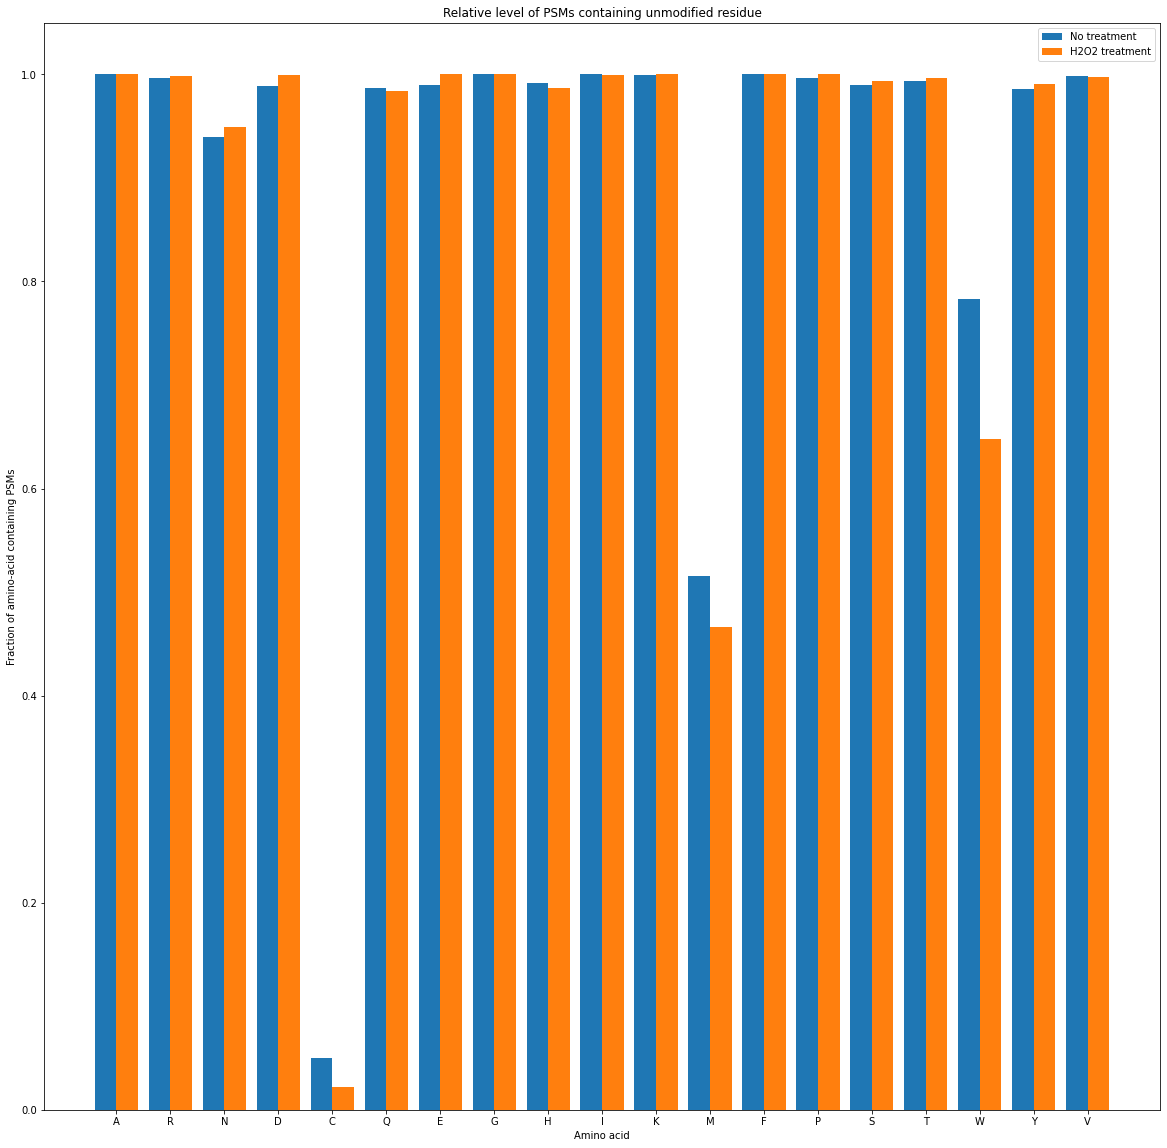

In [31]:
x = RPM2["Amino acid"]
xnone = RPM2["Relative level of PSMs containing unmodified residue_cControl"]
xH = RPM2['Relative level of PSMs containing unmodified residue_cH2O2']
x_axis = np.arange(len(x))

plt.bar(x_axis - 0.2, xnone, 0.4, label = 'No treatment')
plt.bar(x_axis + 0.2, xH, 0.4, label = 'H2O2 treatment')

plt.xticks(x_axis, x)
plt.xlabel("Amino acid")
plt.ylabel("Fraction of amino-acid containing PSMs")
plt.title("Relative level of PSMs containing unmodified residue")
plt.rcParams["figure.figsize"] = (8,8)
plt.legend()
plt.show()

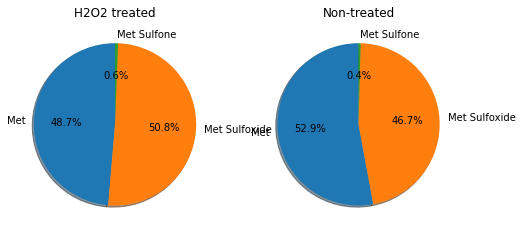

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2)
OA.methionine_overview(H2O2c1000rep, ax1)
OA.methionine_overview(Nonecrep, ax2)
plt.title("Methionine containing peptides")
ax1.set_title("H2O2 treated")
ax2.set_title("Non-treated")
plt.show()

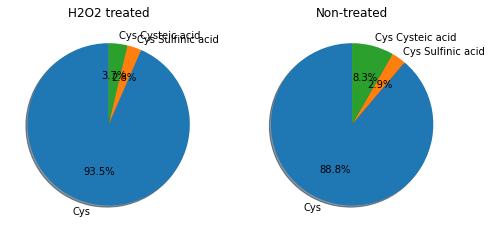

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2)
OA.cysteine_overview(H2O2c1000rep, ax1)
OA.cysteine_overview(Nonecrep, ax2)
plt.title("cysteine containing peptides")
ax1.set_title("H2O2 treated")
ax2.set_title("Non-treated")
plt.show()

In [34]:
os.chdir("/home/robbe/ionbot/differentially_oxidized_psms")

In [35]:
diffox, statement = OA.differentially_oxidized_psms(H2O2c1000rep, Nonecrep)
with open("diffox030782cyto.txt", "w") as f:
    for i in diffox:
        f.write(i)
        f.write("\n")
f.close()

### None mt-YAP vs H2O2 mt-YAP

In [36]:
print("There are this many replicates in the H2O2-mt treatment: {}".format(H2O2mt1000["spectrum_file"].nunique()))


There are this many replicates in the H2O2-mt treatment: 1


In [37]:
mrH2O2mt1000rep = OA.modratios(H2O2mt1000)

In [38]:
modr3 = pd.merge(mrH2O2mt1000rep, mrNonemtrep, on="Modification", suffixes = ('_H2O2mt', '_Nonemt'))
modr3["Difference"] = modr3["Ratios_H2O2mt"] - modr3["Ratios_Nonemt"]
modr3 = modr3.drop(modr3[(modr3["Ratios_H2O2mt"] == 0) | (modr3["Ratios_Nonemt"] == 0)].index)
modr3

,Modification,Ratios_H2O2mt,Ratios_Nonemt,Difference
0,[35]Oxidation[T],0.001882,0.001518,0.000364
1,[35]Oxidation[E],0.001550,0.000955,0.000595
2,[35]Oxidation[S],0.000504,0.000524,-0.000020
3,[35]Oxidation[Q],0.000581,0.000289,0.000291
5,[35]Oxidation[I],0.000685,0.000537,0.000148
7,[35]Oxidation[G],0.000589,0.000294,0.000296
8,[35]Oxidation[W],0.041885,0.031746,0.010139
10,[35]Oxidation[H],0.007389,0.003713,0.003676
11,[35]Oxidation[V],0.001525,0.001231,0.000294
14,[35]Oxidation[Y],0.000558,0.001084,-0.000526


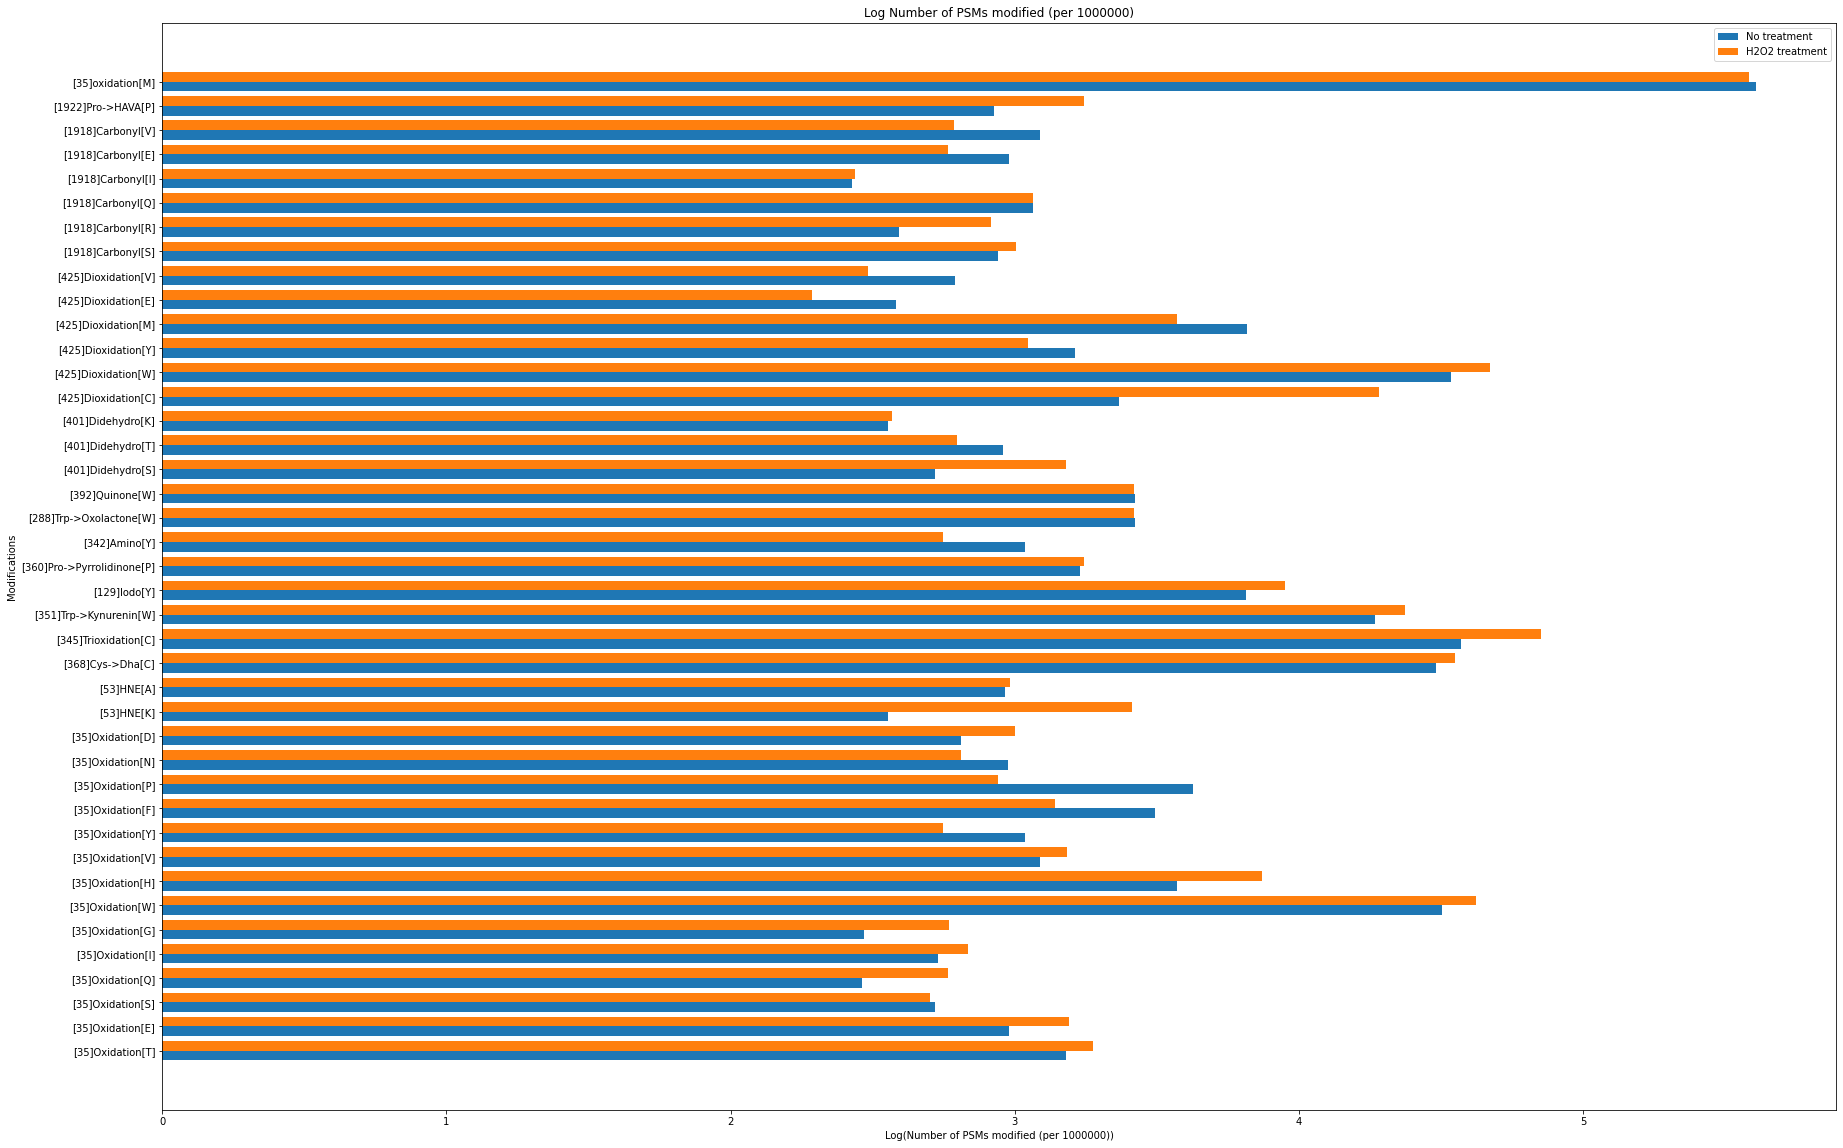

In [39]:
y = modr3["Modification"]
xnone = np.log10(modr3['Ratios_Nonemt']*1000000)
xH = np.log10(modr3['Ratios_H2O2mt']*1000000)
y_axis = np.arange(len(y))

plt.figure(figsize=(30,20))
plt.barh(y_axis - 0.2, xnone, 0.4, label = 'No treatment')
plt.barh(y_axis + 0.2, xH, 0.4, label = 'H2O2 treatment')

plt.yticks(y_axis, y)
plt.ylabel("Modifications")
plt.xlabel("Log(Number of PSMs modified (per 1000000))")
plt.title("Log Number of PSMs modified (per 1000000)")

plt.legend()
plt.show()

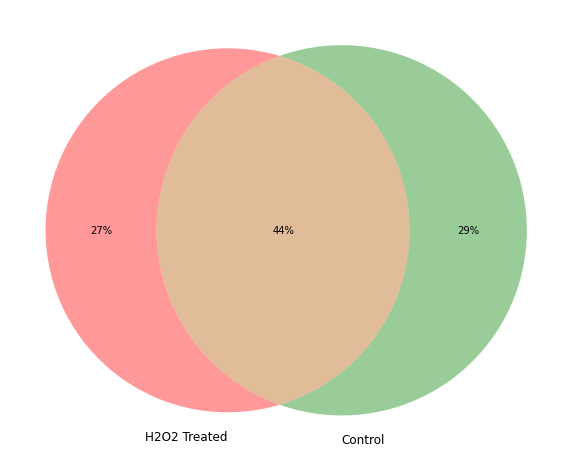

In [40]:
OA.condition_venn([H2O2mt1000, Nonemtrep], ["H2O2 Treated", "Control"])

In [41]:
difflist2, pf_only_treatment2 = OA.comparelist(H2O2mt1000, Nonemtrep)
pf_only_treatment2.head()

,ionbot_match_id,spectrum_file,precursor_mass,peptide_mass,observed_retention_time,charge,database_peptide,matched_peptide,modifications,modifications_delta,...,Secondary treatment,Secondary treatment dose (µM),Length of oxidant treatment (mins),Length of Secondary treatment (mins),Notes,First/Lower/Coeluting,Peptidoform_name,Position,Modification,Oxidatively_modified
11731,0_6445_1,Experiment 1_extH2O2_mt-YAP_1 mM H2O2,1941.00862,19409.9961,2351.16036,3,FASFIDKVQFIEQQNK,FASFIDKVQFIEQQNK,None,0|,...,mt-YAP,0,10,0,YAP1C can react with and trap protein sulfenic...,First,FASFIDKVQFIEQQNK,None,None,False
11732,0_6449_2,Experiment 1_extH2O2_mt-YAP_1 mM H2O2,2077.02675,20770.1832,2351.77812,2,GAVVGIDIGTTNSCVAVMEGK,GAVVGIDIGTTNSCVAVMEGK,14|[4]carbamidomethyl[C],14|57.0215,...,mt-YAP,0,10,0,YAP1C can react with and trap protein sulfenic...,First,GAVVGIDIGTTNSC[4]carbamidomethylVAVMEGK,14,[4]carbamidomethyl[C],False
11734,0_6452_2,Experiment 1_extH2O2_mt-YAP_1 mM H2O2,1864.93520,18649.2740,2352.54336,3,TMQAIEIEIQSQISMK,TMQAIEIEIQSQISMK,2|[35]oxidation[M],2|15.9949,...,mt-YAP,0,10,0,YAP1C can react with and trap protein sulfenic...,First,TM[35]oxidationQAIEIEIQSQISMK,2,[35]oxidation[M],True
11735,0_6454_2,Experiment 1_extH2O2_mt-YAP_1 mM H2O2,1500.79758,14747.7799,2353.15398,2,FIEQQNQVIQTK,FIEQQNQVIQTK,0|[254]Delta:H(2)C(2)[N-TERM],0|26.0157,...,mt-YAP,0,10,0,YAP1C can react with and trap protein sulfenic...,First,[254]Delta:H(2)C(2)FIEQQNQVIQTK,N-term,[254]Delta:H(2)C(2)[N-TERM],False
11736,0_6455_1,Experiment 1_extH2O2_mt-YAP_1 mM H2O2,1273.72275,12737.1826,2353.29348,2,IIVVYPWTQR,IIVVYPWTQR,None,0|,...,mt-YAP,0,10,0,YAP1C can react with and trap protein sulfenic...,First,IIVVYPWTQR,None,None,False


In [42]:
onlytreatment2 = OA.modcounts(pf_only_treatment2)
onlytreatment2 = onlytreatment2.sort_values("Counts", ascending=False).drop(onlytreatment2[onlytreatment2["Counts"] == 0].index, axis = 0)
onlytreatment2

,Modification,Counts
129,[35]oxidation[M],92
33,[345]Trioxidation[C],8
68,[401]Didehydro[S],8
1,[35]Oxidation[E],7
8,[35]Oxidation[W],6
41,[129]Iodo[Y],6
20,[53]HNE[K],4
76,[425]Dioxidation[C],4
38,[351]Trp->Kynurenin[W],3
5,[35]Oxidation[I],3


In [43]:
RPMH2O2mt1000 = OA.relative_PSM_modification(H2O2mt1000)


In [44]:
RPM3 = pd.merge(RPMH2O2mt1000,RPMNonemt, on="Amino acid", suffixes=('_H2O2', '_Control'))
RPM3

,Amino acid,Relative level of PSMs containing unmodified residue_H2O2,Relative level of PSMs containing unmodified residue_Control
0,A,0.998365,0.996799
1,R,0.992201,0.987730
2,N,0.937092,0.933856
3,D,0.965833,0.964401
4,C,0.144928,0.114634
5,Q,0.970928,0.976310
6,E,0.946024,0.953757
7,G,0.997501,0.999006
8,H,0.978172,0.985075
9,I,0.997111,0.998071


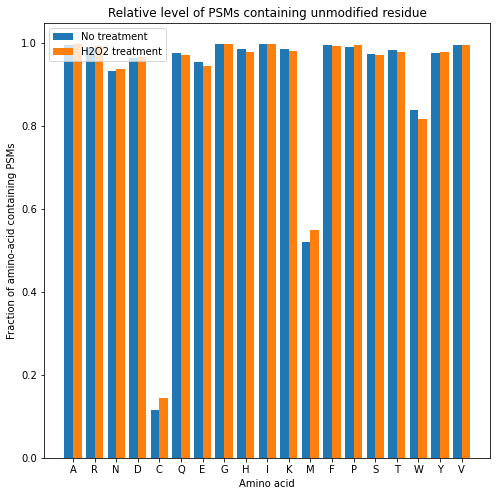

In [45]:
x = RPM3["Amino acid"]
xnone = RPM3["Relative level of PSMs containing unmodified residue_Control"]
xH = RPM3['Relative level of PSMs containing unmodified residue_H2O2']
x_axis = np.arange(len(x))

plt.bar(x_axis - 0.2, xnone, 0.4, label = 'No treatment')
plt.bar(x_axis + 0.2, xH, 0.4, label = 'H2O2 treatment')

plt.xticks(x_axis, x)
plt.xlabel("Amino acid")
plt.ylabel("Fraction of amino-acid containing PSMs")
plt.title("Relative level of PSMs containing unmodified residue")
plt.rcParams["figure.figsize"] = (8,8)
plt.legend()
plt.show()

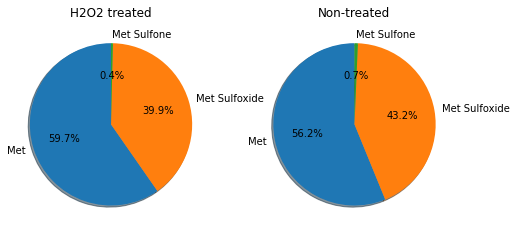

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2)
OA.methionine_overview(H2O2mt1000, ax1)
OA.methionine_overview(Nonemtrep, ax2)
plt.title("Methionine containing peptides")
ax1.set_title("H2O2 treated")
ax2.set_title("Non-treated")
plt.show()

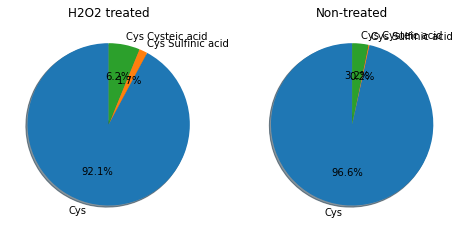

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2)
OA.cysteine_overview(H2O2mt1000, ax1)
OA.cysteine_overview(Nonemtrep, ax2)
plt.title("cysteine containing peptides")
ax1.set_title("H2O2 treated")
ax2.set_title("Non-treated")
plt.show()

In [48]:
os.chdir("/home/robbe/ionbot/differentially_oxidized_psms")

In [49]:
diffox, statement = OA.differentially_oxidized_psms(H2O2mt1000, Nonemtrep)
with open("diffoxPXD030782mt.txt", "w") as f:
    for i in diffox:
        f.write(i)
        f.write("\n")
f.close()

### None po-YAP vs H2O2 po-YAP

In [50]:
print("There are this many replicates in the H2O2-mt treatment: {}".format(H2O2po1000["spectrum_file"].nunique()))


There are this many replicates in the H2O2-mt treatment: 1


In [51]:
mrH2O2po1000rep = OA.modratios(H2O2po1000)

In [52]:
modr4 = pd.merge(mrH2O2po1000rep, mrNoneporep, on="Modification", suffixes = ('_H2O2po', '_Nonepo'))
modr4["Difference"] = modr4["Ratios_H2O2po"] - modr4["Ratios_Nonepo"]
modr4 = modr4.drop(modr4[(modr4["Ratios_H2O2po"] == 0) | (modr4["Ratios_Nonepo"] == 0)].index)
modr4

,Modification,Ratios_H2O2po,Ratios_Nonepo,Difference
0,[35]Oxidation[T],0.002804,0.001704,0.001100
1,[35]Oxidation[E],0.000268,0.000812,-0.000544
3,[35]Oxidation[Q],0.000809,0.000609,0.000200
5,[35]Oxidation[I],0.000954,0.001160,-0.000206
7,[35]Oxidation[G],0.000683,0.000614,0.000069
8,[35]Oxidation[W],0.046429,0.037143,0.009286
10,[35]Oxidation[H],0.009569,0.008805,0.000764
11,[35]Oxidation[V],0.002791,0.001355,0.001436
14,[35]Oxidation[Y],0.000782,0.000569,0.000213
15,[35]Oxidation[F],0.005333,0.001481,0.003852


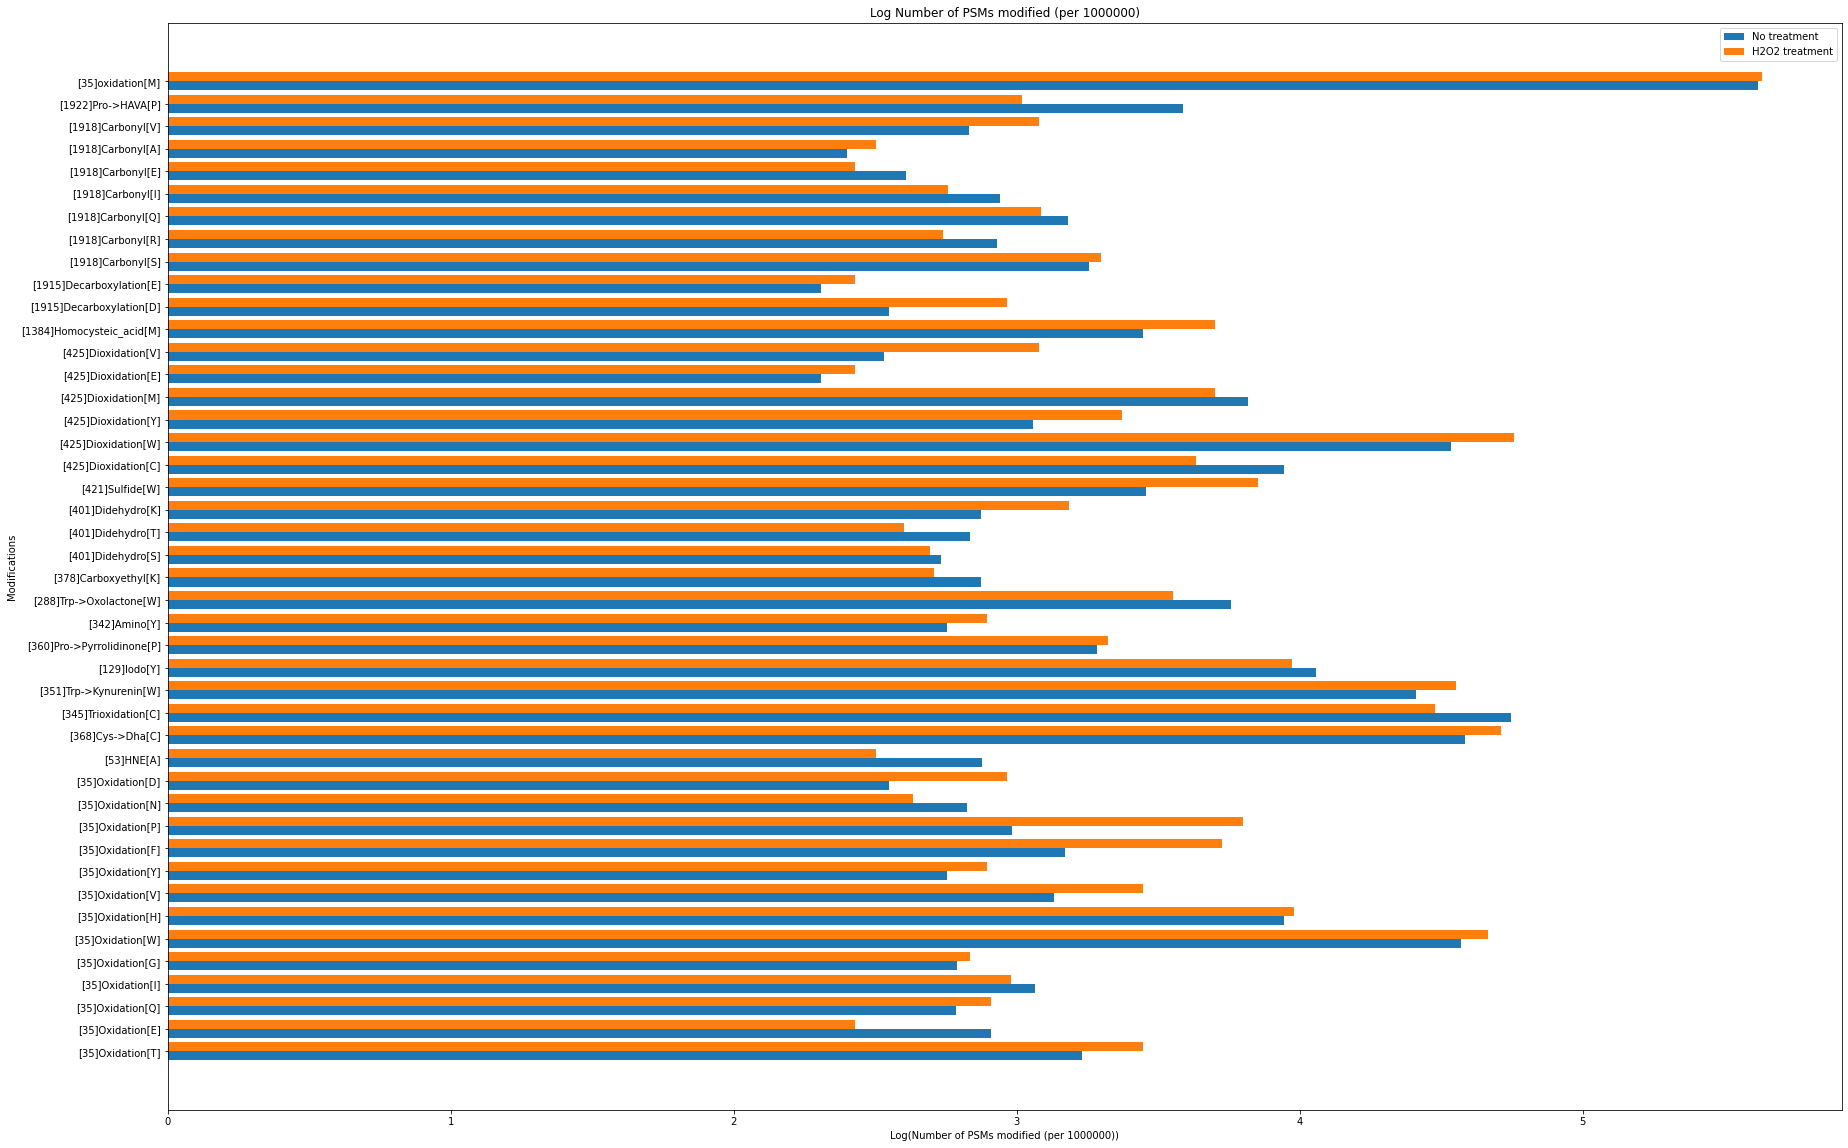

In [53]:
y = modr4["Modification"]
xnone = np.log10(modr4['Ratios_Nonepo']*1000000)
xH = np.log10(modr4['Ratios_H2O2po']*1000000)
y_axis = np.arange(len(y))

plt.figure(figsize=(30,20))
plt.barh(y_axis - 0.2, xnone, 0.4, label = 'No treatment')
plt.barh(y_axis + 0.2, xH, 0.4, label = 'H2O2 treatment')

plt.yticks(y_axis, y)
plt.ylabel("Modifications")
plt.xlabel("Log(Number of PSMs modified (per 1000000))")
plt.title("Log Number of PSMs modified (per 1000000)")

plt.legend()
plt.show()

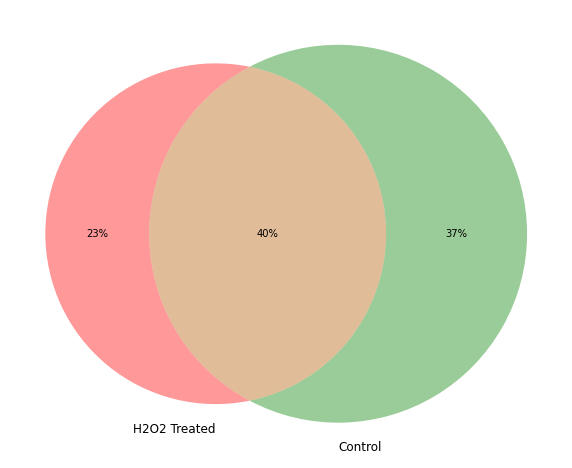

In [54]:
OA.condition_venn([H2O2po1000, Noneporep], ["H2O2 Treated", "Control"])

In [55]:
difflist4, pf_only_treatment4 = OA.comparelist(H2O2po1000, Noneporep)
pf_only_treatment4.head()

,ionbot_match_id,spectrum_file,precursor_mass,peptide_mass,observed_retention_time,charge,database_peptide,matched_peptide,modifications,modifications_delta,...,Secondary treatment,Secondary treatment dose (µM),Length of oxidant treatment (mins),Length of Secondary treatment (mins),Notes,First/Lower/Coeluting,Peptidoform_name,Position,Modification,Oxidatively_modified
19795,0_5825_1,Experiment 1_extH2O2_po-YAP_1 mM H2O2,2281.16175,22801.7497,2485.49574,2,DIINQITKPNDVYSFSIASR,DIINQITKPNDVYSFSIASR,10|[7]Deamidated[N],10|0.9840,...,po-YAP,0,10,0,YAP1C can react with and trap protein sulfenic...,First,DIINQITKPN[7]DeamidatedDVYSFSIASR,1N-term,[7]Deamidated[N],False
19799,0_5839_2,Experiment 1_extH2O2_po-YAP_1 mM H2O2,2427.31072,24593.0936,2488.84758,3,NVIQPSSVDSQTAMVIVNAIVFK,NVIQPSSVDSQTAMVIVNAIVFK,14|[1914]Met->AspSA[M],14|-32.0085,...,po-YAP,0,10,0,YAP1C can react with and trap protein sulfenic...,First,NVIQPSSVDSQTAM[1914]Met->AspSAVIVNAIVFK,14,[1914]Met->AspSA[M],True
19801,0_5843_1,Experiment 1_extH2O2_po-YAP_1 mM H2O2,3264.51338,32635.0655,2489.78886,4,DIENQYETQITQIEHEVSSSGQEVQSSAK,DIENQYETQITQIEHEVSSSGQEVQSSAK,12|[7]Deamidated[Q],12|0.9840,...,po-YAP,0,10,0,YAP1C can react with and trap protein sulfenic...,First,DIENQYETQITQ[7]DeamidatedIEHEVSSSGQEVQSSAK,12,[7]Deamidated[Q],False
19803,0_5849_1,Experiment 1_extH2O2_po-YAP_1 mM H2O2,1814.96226,18139.6140,2492.02530,2,TYIISSIPIQGAFNYK,TYIISSIPIQGAFNYK,None,0|,...,po-YAP,0,10,0,YAP1C can react with and trap protein sulfenic...,First,TYIISSIPIQGAFNYK,None,None,False
19804,0_5850_1,Experiment 1_extH2O2_po-YAP_1 mM H2O2,2474.30632,24743.0160,2492.18022,3,INEGIGQGDISEIPEIHAITAGIK,INEGIGQGDISEIPEIHAITAGIK,None,0|,...,po-YAP,0,10,0,YAP1C can react with and trap protein sulfenic...,First,INEGIGQGDISEIPEIHAITAGIK,None,None,False


In [56]:
onlytreatment3 = OA.modcounts(pf_only_treatment4)
onlytreatment3 = onlytreatment3.sort_values("Counts", ascending=False).drop(onlytreatment3[onlytreatment3["Counts"] == 0].index, axis = 0)
onlytreatment3

,Modification,Counts
129,[35]oxidation[M],102
11,[35]Oxidation[V],6
15,[35]Oxidation[F],6
113,[1918]Carbonyl[S],5
16,[35]Oxidation[P],5
5,[35]Oxidation[I],4
8,[35]Oxidation[W],4
33,[345]Trioxidation[C],3
38,[351]Trp->Kynurenin[W],3
41,[129]Iodo[Y],3


In [57]:
RPMH2O2po1000 = OA.relative_PSM_modification(H2O2po1000)

In [58]:
RPM4 = pd.merge(RPMH2O2po1000, RPMNonepo, on="Amino acid", suffixes=('_H2O2', '_Control'))
RPM4

,Amino acid,Relative level of PSMs containing unmodified residue_H2O2,Relative level of PSMs containing unmodified residue_Control
0,A,0.997235,0.996107
1,R,0.987959,0.984092
2,N,0.934476,0.931461
3,D,0.968549,0.962963
4,C,0.110092,0.113208
5,Q,0.974246,0.968959
6,E,0.956778,0.945926
7,G,0.996642,0.997831
8,H,0.978761,0.973829
9,I,0.996139,0.995244


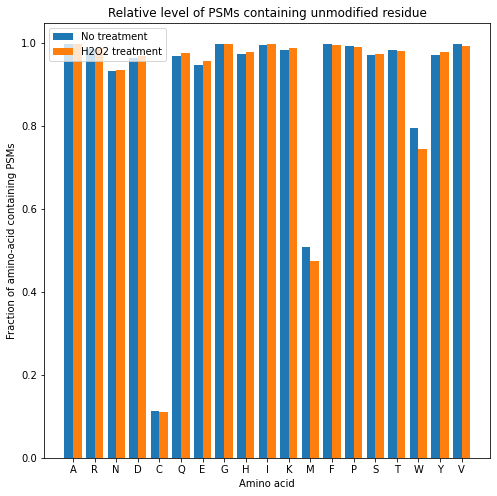

In [59]:
x = RPM4["Amino acid"]
xnone = RPM4["Relative level of PSMs containing unmodified residue_Control"]
xH = RPM4['Relative level of PSMs containing unmodified residue_H2O2']
x_axis = np.arange(len(x))

plt.bar(x_axis - 0.2, xnone, 0.4, label = 'No treatment')
plt.bar(x_axis + 0.2, xH, 0.4, label = 'H2O2 treatment')

plt.xticks(x_axis, x)
plt.xlabel("Amino acid")
plt.ylabel("Fraction of amino-acid containing PSMs")
plt.title("Relative level of PSMs containing unmodified residue")
plt.rcParams["figure.figsize"] = (8,8)
plt.legend()
plt.show()

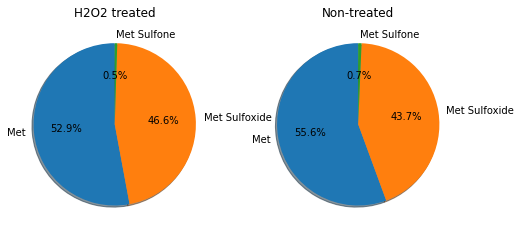

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2)
OA.methionine_overview(H2O2po1000, ax1)
OA.methionine_overview(Noneporep, ax2)
plt.title("Methionine containing peptides")
ax1.set_title("H2O2 treated")
ax2.set_title("Non-treated")
plt.show()

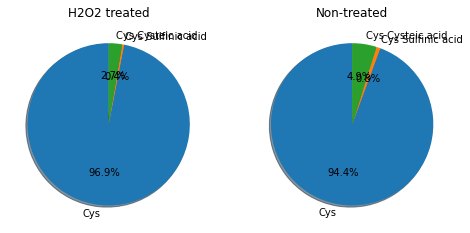

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2)
OA.cysteine_overview(H2O2po1000, ax1)
OA.cysteine_overview(Noneporep, ax2)
plt.title("cysteine containing peptides")
ax1.set_title("H2O2 treated")
ax2.set_title("Non-treated")
plt.show()

In [ ]:
os.chdir("/home/robbe/ionbot/differentially_oxidized_psms")

In [38]:
diffox, statement = OA.differentially_oxidized_psms(H2O2po1000, Noneporep)
with open("diffoxPXD030782peroxi.txt", "w") as f:
    for i in diffox:
        f.write(i)
        f.write("\n")
f.close()

### Concentration dependent analysis of oxPTMs:
0, 10, 30, 100, 300, 1000 µM H2O2

In [76]:
print("There are this many replicates of 0 µM treatment: {}".format(Nonec["spectrum_file"].nunique()))
print("There are this many replicates of 10 µM treatment: {}".format(H2O2c10["spectrum_file"].nunique()))
print("There are this many replicates of 30 µM treatment: {}".format(H2O2c30["spectrum_file"].nunique()))
print("There are this many replicates of 100 µM treatment: {}".format(H2O2c100["spectrum_file"].nunique()))
print("There are this many replicates of 300 µM treatment: {}".format(H2O2c300["spectrum_file"].nunique()))
print("There are this many replicates of 1000 µM treatment: {}".format(H2O2c1000["spectrum_file"].nunique()))

There are this many replicates of 0 µM treatment: 2
There are this many replicates of 10 µM treatment: 1
There are this many replicates of 30 µM treatment: 1
There are this many replicates of 100 µM treatment: 1
There are this many replicates of 300 µM treatment: 1
There are this many replicates of 1000 µM treatment: 2


In [78]:
print("The ratio of PSMs that contain an oxidative modification in the 0 µM treatment subset: {}".format((Nonecrep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))
print("The ratio of PSMs that contain an oxidative modification in the 10 µM treatment subset: {}".format((H2O2c10['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))
print("The ratio of PSMs that contain an oxidative modification in the 30 µM treatment subset: {}".format((H2O2c30['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))
print("The ratio of PSMs that contain an oxidative modification in the 100 µM treatment subset: {}".format((H2O2c100['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))
print("The ratio of PSMs that contain an oxidative modification in the 300 µM treatment subset: {}".format((H2O2c300['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))
print("The ratio of PSMs that contain an oxidative modification in the 1000 µM treatment subset: {}".format((H2O2c1000rep['Oxidatively_modified'].value_counts(normalize=True).mul(100).astype(str)+' %')[1]))

The ratio of PSMs that contain an oxidative modification in the 0 µM treatment subset: 13.595397890699903 %
The ratio of PSMs that contain an oxidative modification in the 10 µM treatment subset: 13.227838377630974 %
The ratio of PSMs that contain an oxidative modification in the 30 µM treatment subset: 12.374487342667233 %
The ratio of PSMs that contain an oxidative modification in the 100 µM treatment subset: 9.533333333333333 %
The ratio of PSMs that contain an oxidative modification in the 300 µM treatment subset: 13.070152040544144 %
The ratio of PSMs that contain an oxidative modification in the 1000 µM treatment subset: 12.764932562620423 %


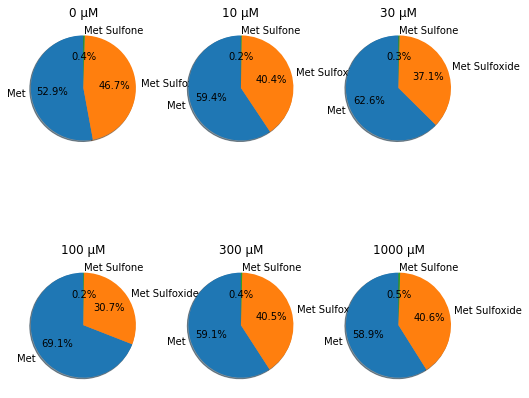

In [84]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3)
OA.methionine_overview(Nonecrep, ax1)
OA.methionine_overview(H2O2c10, ax2)
OA.methionine_overview(H2O2c30, ax3)
OA.methionine_overview(H2O2c100, ax4)
OA.methionine_overview(H2O2c300, ax5)
OA.methionine_overview(H2O2c1000, ax6)
plt.title("Methionine containing peptides")
ax1.set_title("0 µM")
ax2.set_title("10 µM")
ax3.set_title("30 µM")
ax4.set_title("100 µM")
ax5.set_title("300 µM")
ax6.set_title("1000 µM")
plt.show()

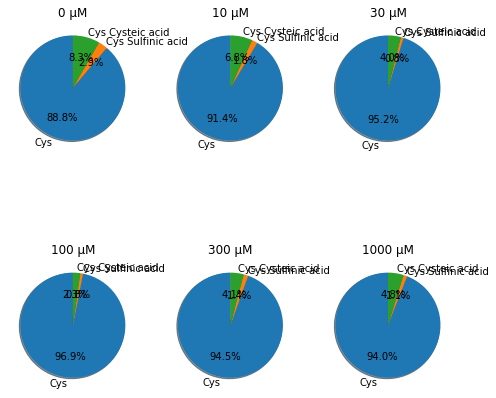

In [85]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3)
OA.cysteine_overview(Nonecrep, ax1)
OA.cysteine_overview(H2O2c10, ax2)
OA.cysteine_overview(H2O2c30, ax3)
OA.cysteine_overview(H2O2c100, ax4)
OA.cysteine_overview(H2O2c300, ax5)
OA.cysteine_overview(H2O2c1000, ax6)
plt.title("cysteine containing peptides")
ax1.set_title("0 µM")
ax2.set_title("10 µM")
ax3.set_title("30 µM")
ax4.set_title("100 µM")
ax5.set_title("300 µM")
ax6.set_title("1000 µM")
plt.show()

# Analysis with quant data

In [84]:
quantN = pd.read_csv('/home/robbe/ionbot/PXD030782/raw_files/QuantifiedPeptides.tsv', sep="\t")
quantN.drop(list(quantN.filter(regex = 'Detection Type|Unnamed')), axis = 1, inplace = True)
quantN.drop(["Protein Groups", "Gene Names", "Organism"], axis =1, inplace = True)

In [89]:
summedintensitiesN = OA.summedintensities(quantN)
conccurveN = summedintensitiesN.filter(regex="Modifications|Experiment 4")
conccurveN = conccurveN[~conccurveN.iloc[:,1:].eq(0).any(1)]
conccurveN

,Modifications,Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_0 uM,Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_10 uM,Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_100 uM,Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_1000 uM,Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_30 uM,Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_300 uM
1,[129]Iodo[Y],20.335103,19.897672,19.466657,18.704729,19.573320,19.209726
31,[340]Bromo[Y],17.494388,14.675775,11.919618,13.708774,13.703238,13.888254
34,[345]Trioxidation[C],16.509215,17.784969,17.710236,19.217244,17.359429,19.160412
39,[351]Trp->Kynurenin[W],23.729950,21.991231,21.483803,19.667739,21.807663,21.073561
42,[354]Nitro[W],16.993275,15.672862,16.280519,15.615457,16.137921,15.949324
44,[35]Oxidation[D],16.274103,13.236679,14.697682,13.121741,15.779684,13.194854
45,[35]Oxidation[E],16.140377,16.881141,12.390226,14.358111,17.863058,17.833000
48,[35]Oxidation[H],14.483883,11.136469,10.239010,15.646787,16.106645,13.775173
49,[35]Oxidation[I],14.054260,16.607537,17.307904,19.571559,19.590298,17.604999
52,[35]Oxidation[P],20.530304,20.587782,13.918030,19.866078,19.664053,19.677435


In [90]:
conccurveTN = conccurveN.T
conccurveTN.columns = conccurveTN.iloc[0]
conccurveTN = conccurveTN.drop(conccurveTN.index[0])

In [94]:
conccurveTN["Concentration H2O2"] = [0,10,100,1000,30,300]
conccurveTN

Modifications,[129]Iodo[Y],[340]Bromo[Y],[345]Trioxidation[C],[351]Trp->Kynurenin[W],[354]Nitro[W],[35]Oxidation[D],[35]Oxidation[E],[35]Oxidation[H],[35]Oxidation[I],[35]Oxidation[P],[35]oxidation[M],[368]Cys->Dha[C],[401]Didehydro[S],[425]Dioxidation[C],[425]Dioxidation[M],[425]Dioxidation[W],[425]Dioxidation[Y],[53]HNE[C],Concentration,Concentration H2O2
Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_0 uM,20.335103,17.494388,16.509215,23.72995,16.993275,16.274103,16.140377,14.483883,14.05426,20.530304,27.291389,20.853646,16.358209,18.864984,14.903207,15.565088,13.478461,13.980016,0,0
Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_10 uM,19.897672,14.675775,17.784969,21.991231,15.672862,13.236679,16.881141,11.136469,16.607537,20.587782,27.388141,15.339441,13.077528,14.261447,14.636806,15.279676,12.747861,14.243644,10,10
Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_100 uM,19.466657,11.919618,17.710236,21.483803,16.280519,14.697682,12.390226,10.23901,17.307904,13.91803,26.619148,19.684777,14.163262,17.244779,11.912173,15.222198,12.085497,15.034778,100,100
Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_1000 uM,18.704729,13.708774,19.217244,19.667739,15.615457,13.121741,14.358111,15.646787,19.571559,19.866078,27.065071,19.168236,13.938005,14.993396,14.743367,14.421007,12.077572,14.910055,1000,1000
Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_30 uM,19.57332,13.703238,17.359429,21.807663,16.137921,15.779684,17.863058,16.106645,19.590298,19.664053,27.177421,15.573181,12.842982,16.48328,15.066921,15.465776,12.960724,15.583441,30,30
Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_300 uM,19.209726,13.888254,19.160412,21.073561,15.949324,13.194854,17.833,13.775173,17.604999,19.677435,27.395071,19.629944,14.639796,14.386975,15.383489,13.207352,12.051514,15.300302,300,300


<AxesSubplot:xlabel='Concentration H2O2', ylabel='[53]HNE[C]'>

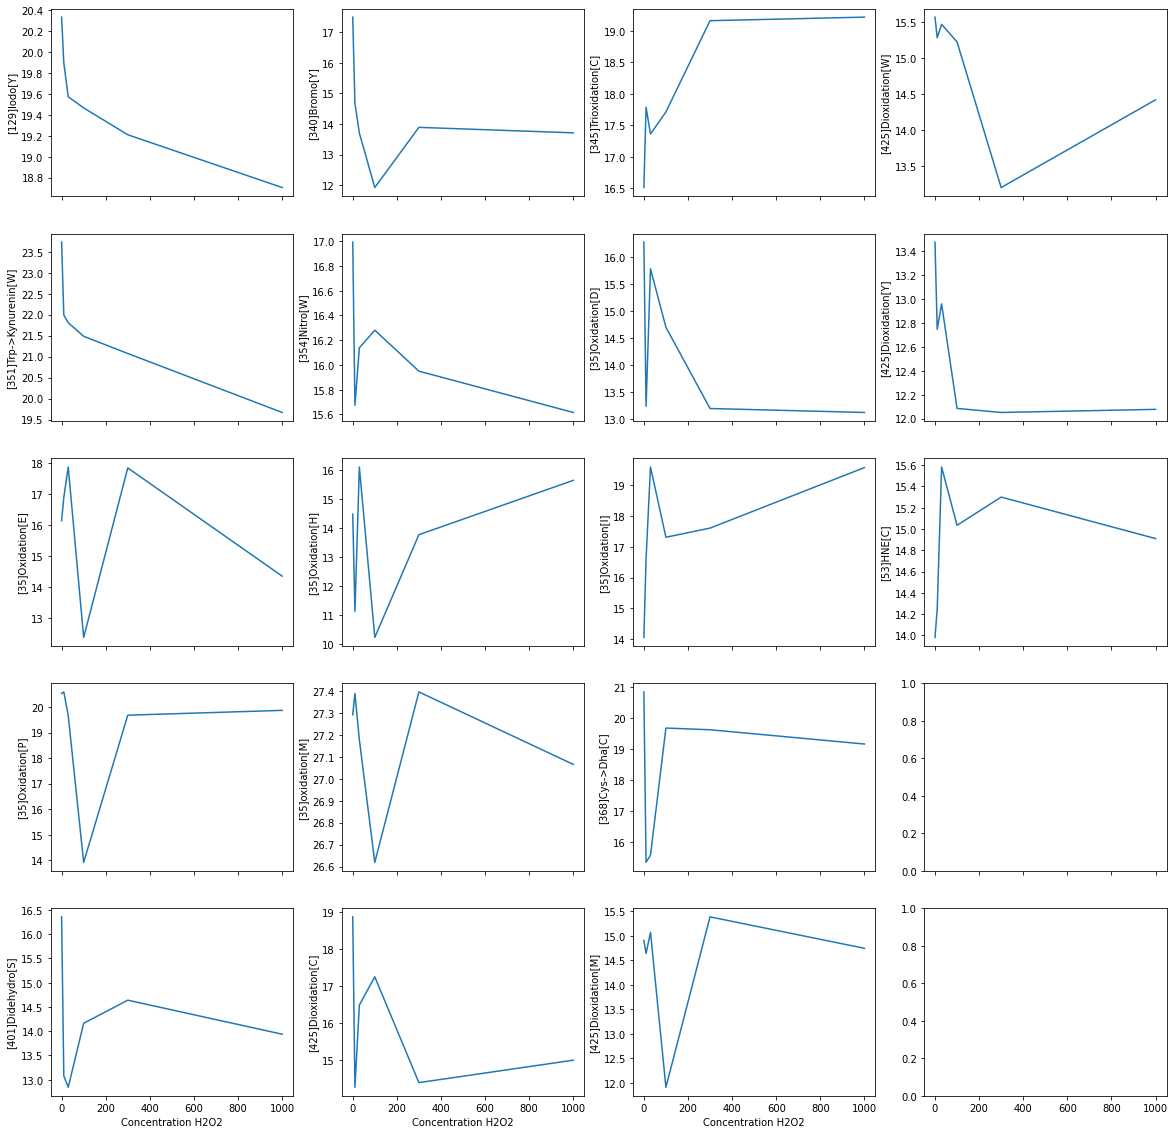

In [100]:
fig, axs = plt.subplots(5,4, sharex=True)
fig.set_size_inches(20,20)
z=0
for x in range(5):
    for y in range(3):
        sns.lineplot(ax=axs[x,y], data=conccurveTN, x='Concentration H2O2', y= conccurveTN.columns[z])
        z+=1
sns.lineplot(ax=axs[0,3], data=conccurveTN, x='Concentration H2O2', y=conccurveTN.columns[15])
sns.lineplot(ax=axs[1,3], data=conccurveTN, x='Concentration H2O2', y=conccurveTN.columns[16])
sns.lineplot(ax=axs[2,3], data=conccurveTN, x='Concentration H2O2', y=conccurveTN.columns[17])

In [102]:
Nonmodified = quant.loc[quant["Sequence"].str.endswith("nan") & quant["Base Sequence"].str.contains("M")]
Sulfoxide = quant.loc[quant["Sequence"].str.contains("[35]oxidation[M]",regex=False)]
Sulfone = quant.loc[quant["Sequence"].str.contains("[425]Dioxidation[M]", regex = False)]
Nonmodifiednums = Nonmodified.append(Nonmodified.sum(numeric_only=True), ignore_index=True)[-1:]
Sulfoxidenums = Sulfoxide.append(Sulfoxide.sum(numeric_only=True), ignore_index=True)[-1:]
Sulfonenums = Sulfone.append(Sulfone.sum(numeric_only=True), ignore_index=True)[-1:]
moddf = [Nonmodifiednums, Sulfoxidenums, Sulfonenums]

In [120]:
labels = ["Met", "Met Sulfoxide", "Met Sulfone"]
sizes0 = [Nonmodifiednums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_0 uM"].values[0], Sulfoxidenums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_0 uM"].values[0], Sulfonenums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_0 uM"].values[0]]
sizes10 = [Nonmodifiednums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_10 uM"].values[0], Sulfoxidenums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_10 uM"].values[0], Sulfonenums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_10 uM"].values[0]]
sizes30 = [Nonmodifiednums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_30 uM"].values[0], Sulfoxidenums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_30 uM"].values[0], Sulfonenums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_30 uM"].values[0]]
sizes100 = [Nonmodifiednums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_100 uM"].values[0], Sulfoxidenums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_100 uM"].values[0], Sulfonenums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_100 uM"].values[0]]
sizes300 = [Nonmodifiednums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_300 uM"].values[0], Sulfoxidenums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_300 uM"].values[0], Sulfonenums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_300 uM"].values[0]]
sizes1000 = [Nonmodifiednums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_1000 uM"].values[0], Sulfoxidenums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_1000 uM"].values[0], Sulfonenums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_1000 uM"].values[0]]

In [121]:
sizes0

[1793557357.247398, 574904817.4341965, 115556.46484375]

<function matplotlib.pyplot.show(close=None, block=None)>

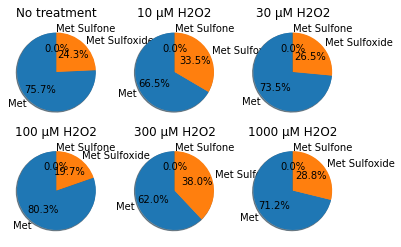

In [122]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3)
ax1.pie(sizes0, labels=labels, autopct='%1.1f%%', shadow= True, startangle = 90)
ax2.pie(sizes10, labels=labels, autopct='%1.1f%%', shadow= True, startangle = 90)
ax3.pie(sizes30, labels = labels, autopct='%1.1f%%', shadow= True, startangle = 90)
ax4.pie(sizes100, labels=labels, autopct='%1.1f%%', shadow= True, startangle = 90)
ax5.pie(sizes300, labels=labels, autopct='%1.1f%%', shadow= True, startangle = 90)
ax6.pie(sizes1000, labels=labels, autopct='%1.1f%%', shadow= True, startangle = 90)
ax1.set_title("No treatment")
ax2.set_title("10 µM H2O2")
ax3.set_title("30 µM H2O2")
ax4.set_title("100 µM H2O2")
ax5.set_title("300 µM H2O2")
ax6.set_title("1000 µM H2O2")
plt.show

In [123]:
NonmodifiedC = quant.loc[quant["Sequence"].str.endswith("nan") & quant["Base Sequence"].str.contains("C")]
Sulfenic = quant.loc[quant["Sequence"].str.contains("[35]oxidation[C]",regex=False)]
Sulfinic = quant.loc[quant["Sequence"].str.contains("[425]Dioxidation[C]", regex = False)]
Cysteic = quant.loc[quant["Sequence"].str.contains("[345]Trioxidation[C]", regex = False)]

In [124]:
NonmodifiedCnums = NonmodifiedC.append(NonmodifiedC.sum(numeric_only=True), ignore_index=True)[-1:]
Sulfenicnums = Sulfenic.append(Sulfenic.sum(numeric_only=True), ignore_index=True)[-1:]
Sulfinicnums = Sulfinic.append(Sulfinic.sum(numeric_only=True), ignore_index=True)[-1:]
Cysteicnums = Cysteic.append(Cysteic.sum(numeric_only=True), ignore_index=True)[-1:]
moddf = [NonmodifiedCnums, Sulfenicnums, Sulfinicnums, Cysteicnums]

In [131]:
labels = ["Cys", "Sulfinic acid", "Cysteic acid"]
sizes0 = [NonmodifiedCnums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_0 uM"].values[0], Sulfinicnums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_0 uM"].values[0], Cysteicnums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_0 uM"].values[0]]
sizes10 = [NonmodifiedCnums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_10 uM"].values[0], Sulfinicnums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_10 uM"].values[0], Cysteicnums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_10 uM"].values[0]]
sizes30 = [NonmodifiedCnums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_30 uM"].values[0], Sulfinicnums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_30 uM"].values[0], Cysteicnums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_30 uM"].values[0]]
sizes100 = [NonmodifiedCnums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_100 uM"].values[0], Sulfinicnums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_100 uM"].values[0], Cysteicnums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_100 uM"].values[0]]
sizes300 = [NonmodifiedCnums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_300 uM"].values[0], Sulfinicnums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_300 uM"].values[0], Cysteicnums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_300 uM"].values[0]]
sizes1000 = [NonmodifiedCnums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_1000 uM"].values[0], Sulfinicnums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_1000 uM"].values[0], Cysteicnums["Intensity_Experiment 4_extH2O2_c-YAP_concentration curve_1000 uM"].values[0]]

In [134]:
import matplotlib as mpl

<function matplotlib.pyplot.show(close=None, block=None)>

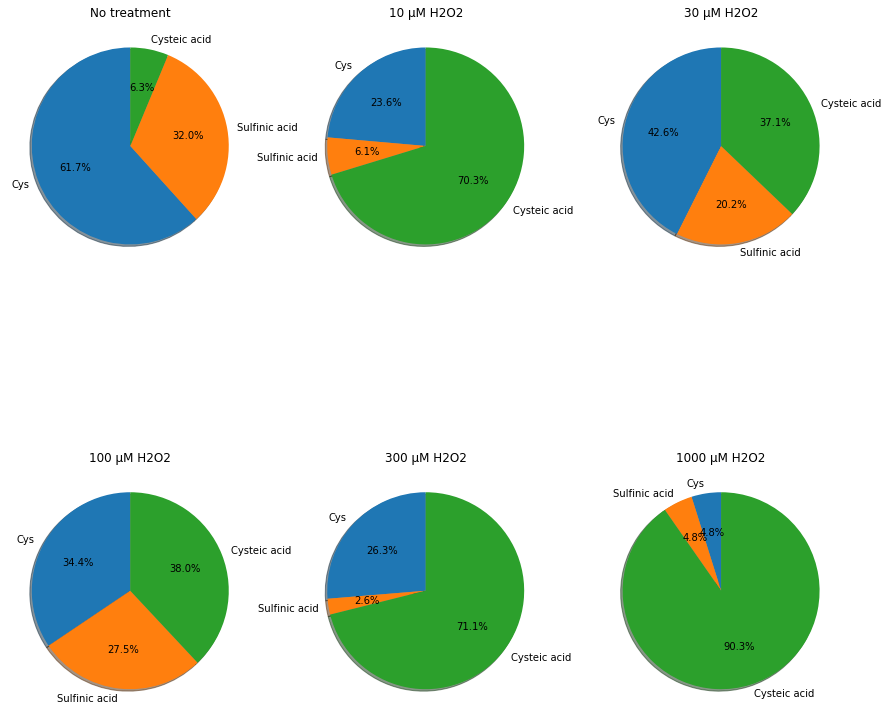

In [143]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3)

ax1.pie(sizes0, labels=labels, autopct='%1.1f%%', shadow= True, startangle = 90)
ax2.pie(sizes10, labels=labels, autopct='%1.1f%%', shadow= True, startangle = 90)
ax3.pie(sizes30, labels = labels, autopct='%1.1f%%', shadow= True, startangle = 90)
ax4.pie(sizes100, labels=labels, autopct='%1.1f%%', shadow= True, startangle = 90)
ax5.pie(sizes300, labels=labels, autopct='%1.1f%%', shadow= True, startangle = 90)
ax6.pie(sizes1000, labels=labels, autopct='%1.1f%%', shadow= True, startangle = 90)
ax1.set_title("No treatment")
ax2.set_title("10 µM H2O2")
ax3.set_title("30 µM H2O2")
ax4.set_title("100 µM H2O2")
ax5.set_title("300 µM H2O2")
ax6.set_title("1000 µM H2O2")
fig.set_size_inches(15,15)
plt.show

Remember: sulfenylated (C doubly oxidized) proteins were extracted